# Data Exploration on Data Expo 2009: Airline on time data
## by Houssem Menhour

## Investigation Overview

In this presentation, I'll be showcasing some key findings from my EDA process on the dataset described bellow.

My main interest is investigating flight delay times in relation to other vaiables.

## Dataset Overview

In this project I'll analyze and visualize my findings on the flights dataset suggested by Udacity, with a focus on the time period from 2000 to 2002.

The provided link does not lead to an easily downloadable source, so I used [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7) as an alternative source to get the data.

In [2]:
import os

# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set()

**Data loading and wrangling**

In [3]:
# Parsing columns is a memory intensive task, providing dtypes makes laoding data quicker and consumes less memory
# https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

df_types = {
"Year": int,
"Month": int,
"DayofMonth": int,
"DayOfWeek": int,
"DepTime": str,
"CRSDepTime": str,
"ArrTime": str,
"CRSArrTime": str,
"UniqueCarrier": str,
"FlightNum": str,
"TailNum": str,
"ActualElapsedTime": float,
"CRSElapsedTime": float,
"AirTime": float,
"ArrDelay": float,
"DepDelay": float,
"Origin": str,
"Dest": str,
"Distance": int,
"TaxiIn": int,
"TaxiOut": int,
"Cancelled": bool,
"CancellationCode": str,
"Diverted": bool,
"CarrierDelay": float,
"WeatherDelay": float,
"NASDelay": float,
"SecurityDelay": float,
"LateAircraftDelay": float
}

In [4]:
data_folder = "../datasets/P5_2/"
data_years = [2000, 2001, 2002]

df = pd.concat((pd.read_csv(os.path.join(data_folder, "{}.csv".format(y)), encoding='latin-1', dtype=df_types) for y in data_years))

In [5]:
carriers_path = "../datasets/P5_2/carriers.csv"
df_carr = pd.read_csv(carriers_path, encoding='latin-1', dtype={'Code': str, 'Description': str})

**Notes**

* The data contains 29 variables and 16,922,186 entries for a total of 3.6GB
* `CancellationCode` and the last 5 columns are all `NA` for the selected period and can be dropped (Data starts 6/2003)
* Time data should be parsed correctly as `datetime`
* Some entries have an `AirTime` bellow 0, which is impossibles

In [6]:
#Create a copy of the dataset before any modifications
cols_to_drop = ['CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'FlightNum', 'TailNum', 'TaxiIn', 'TaxiOut', 'DepTime', 'ArrTime', 'CRSArrTime']
df2 = df.copy().drop(cols_to_drop, axis = 1)

In [7]:
# parsing datetime and get hour of day, we only need DepTime
#datetime_list = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']
datetime_list = ['CRSDepTime']
for col in datetime_list:
    df2[col] = pd.to_datetime(df2[col].apply(lambda x: str(x).zfill(4)), format='%H%M', errors='coerce').dt.hour

In [8]:
# new dataframe without cancelled and diverted flights
df3 = df2[df2['Cancelled'] != True]
df3 = df3[df3['Diverted'] != True]
df3 = df3[df3['AirTime'] > 0]
df3 = df3.drop(['Cancelled', 'Diverted'], axis = 1)

In [9]:
group_list = ['Year','Month','DayOfWeek','UniqueCarrier', 'Origin', 'Dest']
group_list2 = ['Year','Month','DayofMonth','UniqueCarrier', 'Origin', 'Dest']
agg_map = {
    'ActualElapsedTime': 'mean',
    'CRSElapsedTime': 'mean',
    'AirTime': 'mean',
    'ArrDelay': 'mean',
    'DepDelay': 'mean',
    'Distance': 'mean',
}

In [10]:
df_agg = df3.groupby(group_list).agg(agg_map).reset_index()

In [11]:
df_agg2 = df3.groupby(group_list2).agg(agg_map).reset_index()

### What is the structure of your dataset?

* This dataset comes in 16,922,186 entries and 29 columns between numerical and categorical types, totalling 3.6GB.
* Some of the numerical variables represent time information.

### What is/are the main feature(s) of interest in your dataset?

* I'm interested in evaluating departure delay times `DepTime` the various airlines and how it changes over time.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

* `DepDelay` itself as well as `UniqueCarrier` and datetime related information should be helpful in finding some insights regarding this data.
* Data on delay reasons would have been very helpfull but it is not available for this time window.

## Univariate Exploration

## Cancelled and Diverted Flights

A total of 3.1% of all flights has been either cancelled or diverted.

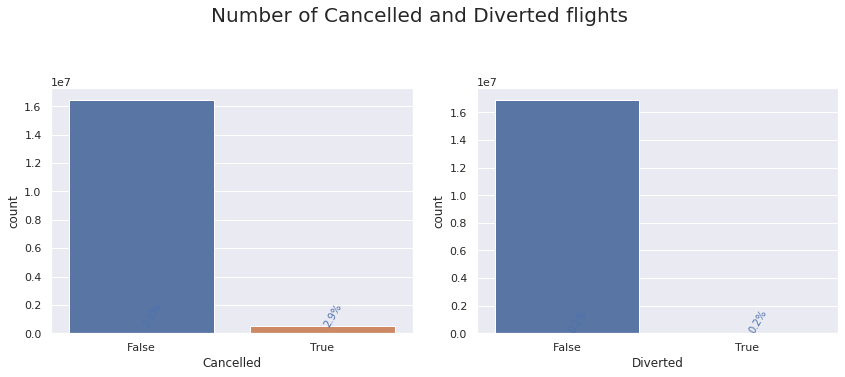

In [12]:
cols_interest = ['Cancelled', 'Diverted']

f = plt.figure(figsize=(12, 8))
gs = f.add_gridspec(len(cols_interest), 2)
for i, col in enumerate(cols_interest):
    ax = f.add_subplot(gs[int(i/2),i%2])
    #sns.boxplot(df2[col], kind="box");
    ax = sns.countplot(df2[col])
    ax.set_xticklabels(ax.get_xticklabels())
    #sns.distplot(df2[col], kde=False);
    # add annotations
    n_points = df2.shape[0]
    col_counts = df2[col].value_counts()
    locs, labels = plt.xticks() # get the current tick locations and labels

    # loop through each pair of locations and labels
    for loc, label in zip(locs, labels):

        # get the text property for the label to get the correct count
        count = col_counts[bool(label.get_text())]
        pct_string = '{:0.1f}%'.format(100*count/n_points)

        # print the annotation just below the top of the bar
        plt.text(loc, count+10, pct_string, ha = 'left', color = 'b', rotation=60, fontsize=10)

f.suptitle('Number of Cancelled and Diverted flights', fontsize=20, y = 1.1)
f.tight_layout()

* a total of 3.1% of all flights has been either cancelled or diverted

In [13]:
#df_canc = df2[df2['Cancelled'] == True]
#df_div = df2[df2['Diverted'] == True]

## Flights distribution per Carrier

Some carriers have more dominance over the market than others.

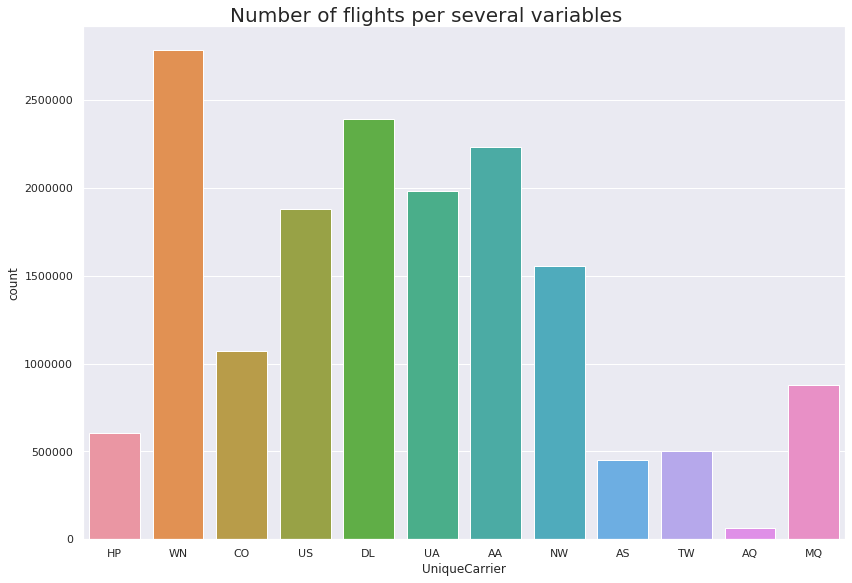

In [14]:
f = plt.figure(figsize=(12, 8))
ax = sns.countplot(df3['UniqueCarrier'])
f.suptitle('Number of flights per several variables', fontsize=20, y = 1.01)
f.tight_layout()

## Flight distance and air time distribution

* Most flights are relatively short which is to be expected considering that the data is only for US domestic flights.

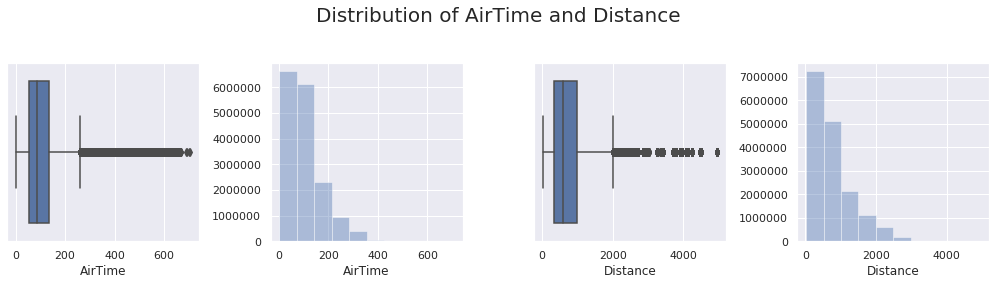

In [15]:
cols_interest = ['AirTime', 'Distance']

f = plt.figure(figsize=(14, 6))
gs = f.add_gridspec(len(cols_interest), 4)
for i, col in enumerate(cols_interest):
    ix, iy= int(i/2), (2 if i%2 else 0)
    ax = f.add_subplot(gs[ix,iy])
    ax = sns.boxplot(df3[col]);
    ax = f.add_subplot(gs[ix,iy+1])
    ax = sns.distplot(df3[col], bins = 10, kde=False);

f.suptitle('Distribution of AirTime and Distance', fontsize=20, y = 1.1)
f.tight_layout()

## DepDelay and ArrDelay Distribution

* While most flights take of on time or with minor delays, there is still a significant number of outliers with very long delay times.
* Zooming in on the distribution only strengthens the earlier notion.

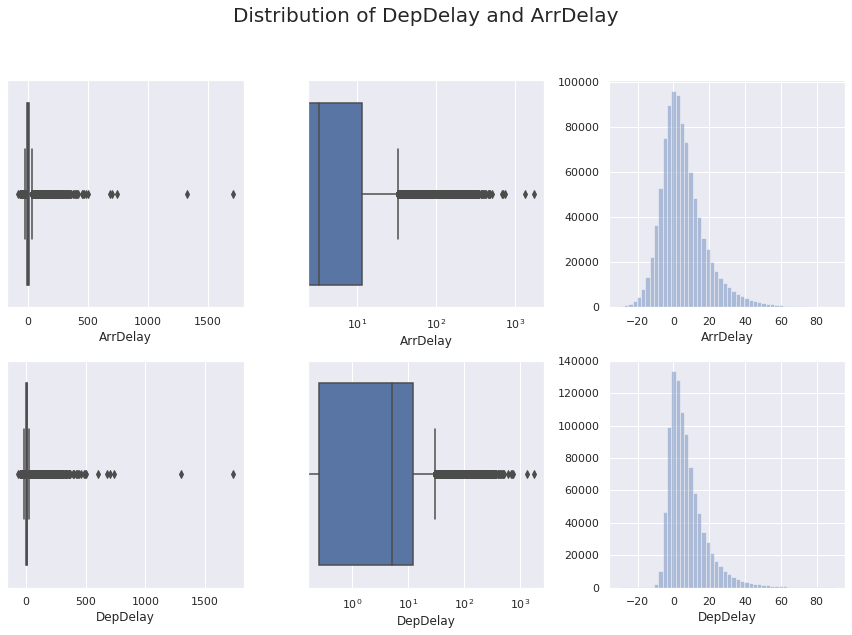

In [16]:
cols_interest = ['ArrDelay', 'DepDelay']

f = plt.figure(figsize=(12, 8))
gs = f.add_gridspec(len(cols_interest), 3)
for i, col in enumerate(cols_interest):
    
    ax = f.add_subplot(gs[i,0])
    ax = sns.boxplot(df_agg[col]);
    
    ax = f.add_subplot(gs[i,1])
    ax = sns.boxplot(df_agg[col]);
    ax.set(xscale="log");
    
    ax = f.add_subplot(gs[i,2])
    ax = sns.distplot(df_agg[col], kde=False, hist_kws={"range": [-30,90]});
        
f.suptitle('Distribution of DepDelay and ArrDelay', fontsize=20, y = 1.1)
f.tight_layout()

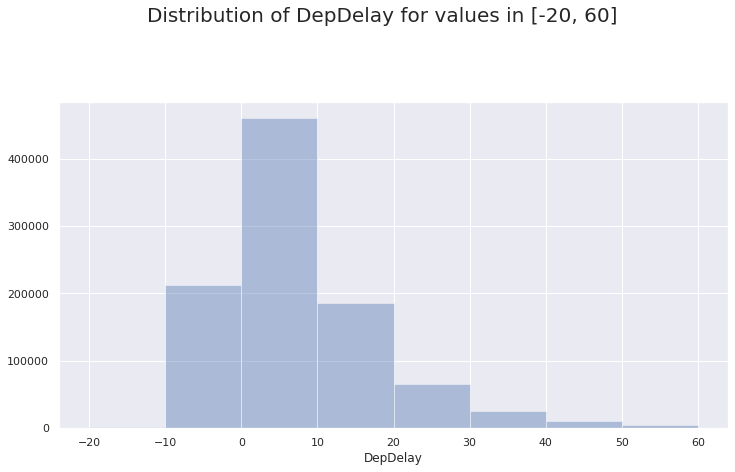

In [17]:
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.distplot(df_agg['DepDelay'], bins = 8, kde=False, hist_kws={"range": [-20,60]});
f.suptitle('Distribution of DepDelay for values in [-20, 60]', fontsize=20, y = 1.1)
plt.show()

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

* The distribution of my variables of interest, `DepDelay` and `ArrDelay`, were very skewed and had lots of outliers.
* It needed to use a logarithmic scale to make it more readable.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

* as the opposite of my expectations, the number of flights didn't change much between months, years and days of month/week, except for a minor slow down on Fridays.
* The number of flights per carrier varries a lot however, showing a market dominance for some carriers such as Southwest Airlines and Delta Air Lines .

## Bivariate Exploration

## Finding Correlations

* There are no strong correlations between ArrDelay, DepDelay and other variables, we need to investigate further.

In [18]:
# Before calculating correlations, we need to encode time data in a way to better reflect its periodic nature
# applying a trigonometric transform will do the trick

cols_interest = ['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime']
df_corr = df3.copy()
for col in cols_interest:
    df_corr[col] = np.sin(2*np.pi*df_corr[col]/24.)
    
#Correlation matrix between features
corr_mat = df_corr.corr().abs()

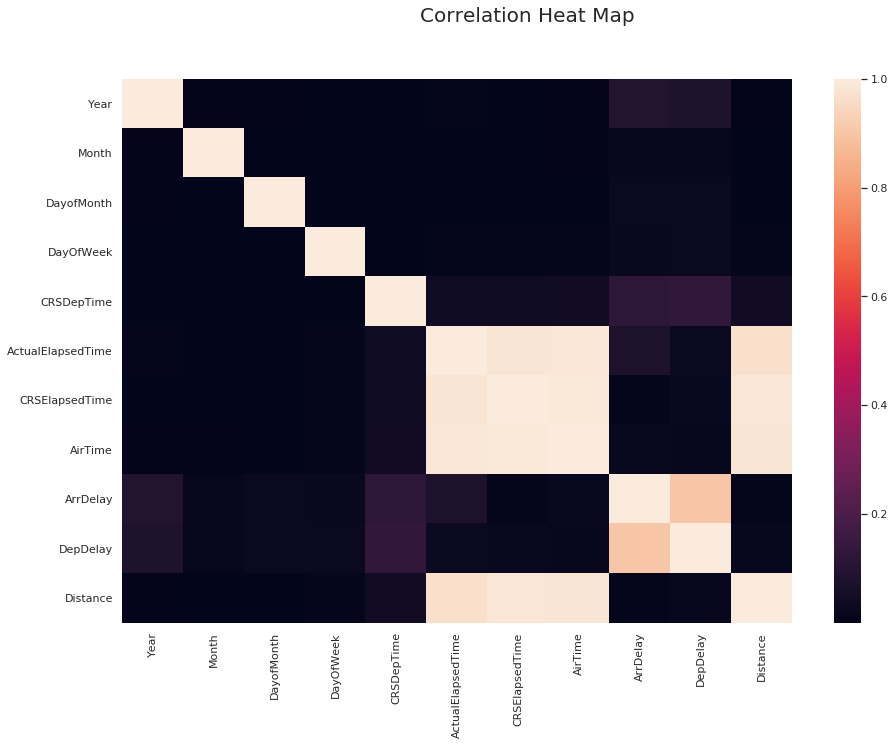

In [19]:
#Plot the heatmap with seaborn
plt.figure(figsize=(15,10)) 
sns.heatmap(corr_mat, 
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns);

plt.suptitle('Correlation Heat Map', fontsize=20);

## DepDelay vs Categorical variables

* Interesting, while the correlation is not that strong as mentioned earlier, it seems that the first days of every week, and of every month see slightly less delays then the rest.
* We also see an overal improvement year over year.

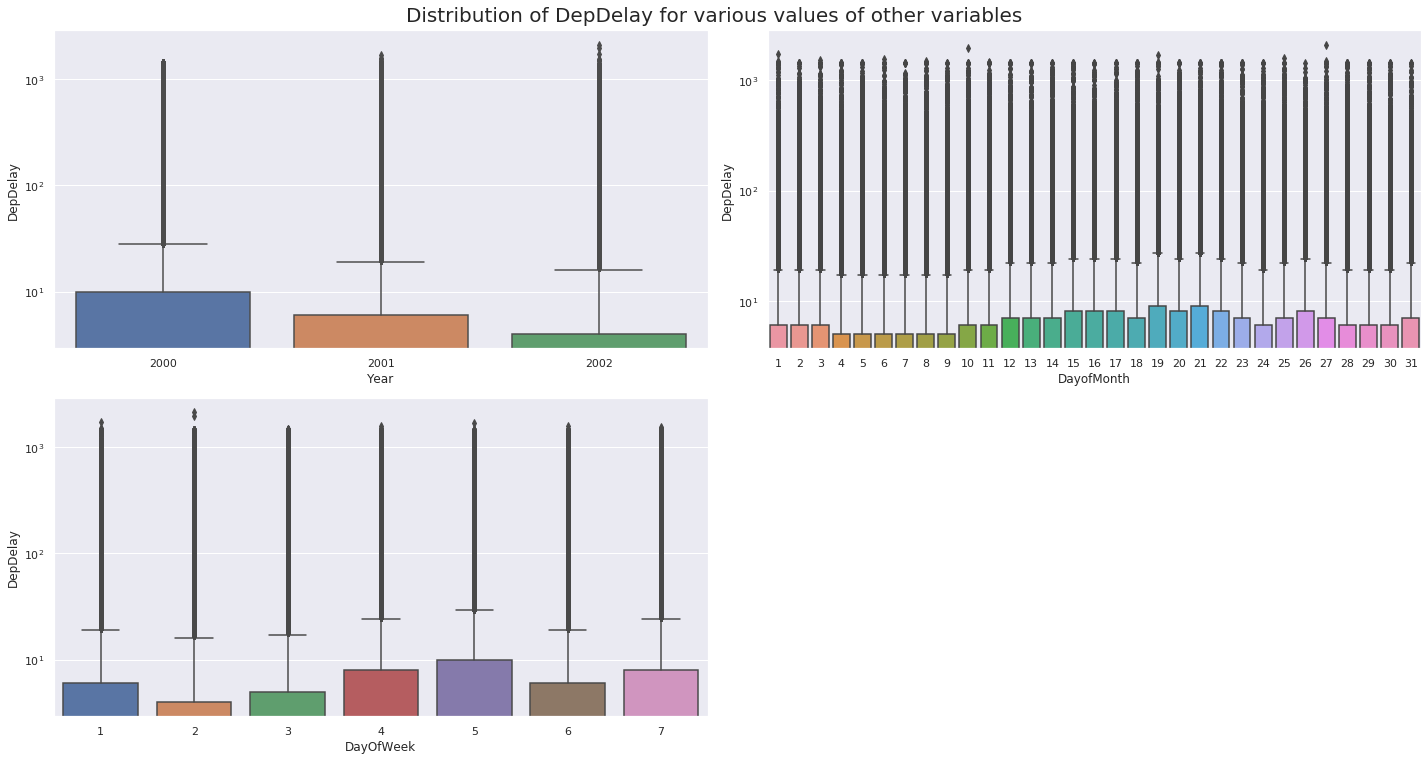

In [30]:
cols_interest = ['Year', 'DayofMonth', 'DayOfWeek']
    
f = plt.figure(figsize=(20, 15))
gs = f.add_gridspec(len(cols_interest), 2)
for i, col in enumerate(cols_interest):
    ax = f.add_subplot(gs[int(i/2),i%2])
    #sns.boxplot(df2[col], kind="box");
    ax = sns.boxplot(x=col, y="DepDelay", data=df3)
    ax.set(yscale="log");
    #sns.distplot(df2[col], kde=False);
    ax.set_xticklabels(ax.get_xticklabels())
        
f.suptitle('Distribution of DepDelay for various values of other variables', fontsize=20, y = 1.01)
f.tight_layout()

## AirTime vs Distance

Comes as no surprise, showing that distance and airtime have indeed a direct correlation.

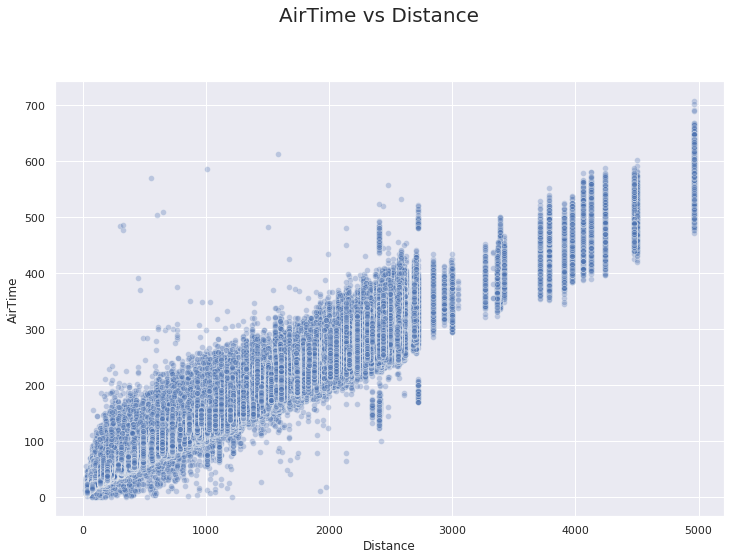

In [21]:
f = plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x='Distance', y="AirTime", data=df3, alpha = 0.3);
f.suptitle('AirTime vs Distance', fontsize=20, y = 1.01);

## Flight numbers over time

A sharp dip in the number of flights since September 2001, a direct result of the 9/11 attacks.

In [22]:
df_tmp = df3.groupby(['Year', 'Month']).agg({'DayofMonth': 'count', 'DepDelay':'mean'}).rename(columns ={'DayofMonth':'NumberofFlights'})

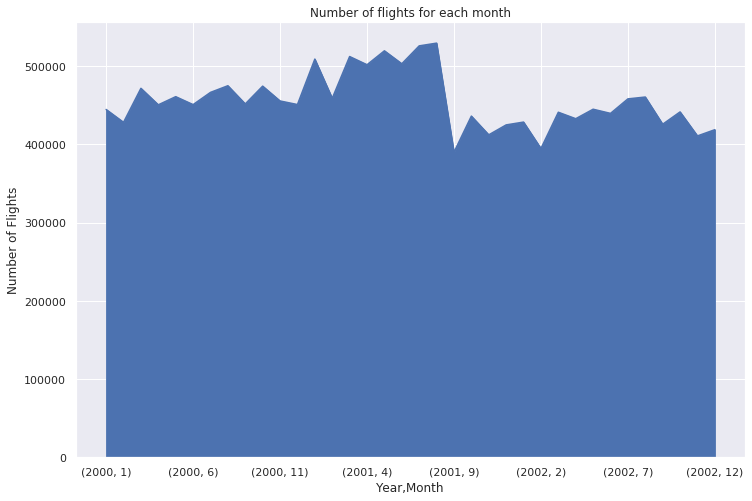

In [23]:
ax = df_tmp.drop(['DepDelay'], axis = 1).plot(figsize=(12,8), kind = 'area', legend = False, title = "Number of flights for each month")
ax.set(ylabel="Number of Flights");

## Delay Averages over time

* Seems like delays spike up in june and december of each year, which aligns perfectly with summer and end of year holidays.
* Since previous exploration showed us no difference in the number of flights, it might be a an indicator of a higher number of passengers and more crowded flights.

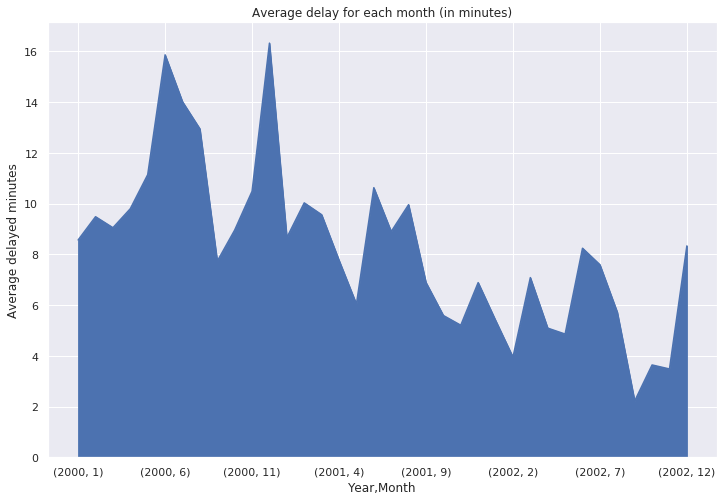

In [24]:
ax = df_tmp.drop(['NumberofFlights'], axis = 1).plot(figsize=(12,8), kind = 'area', legend = False, title = "Average delay for each month (in minutes)")
ax.set(ylabel="Average delayed minutes");

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

* Some months see a clear rise in the average duration of delays.
* delays continuously reduced year over year.
* First days of each week and of each month have less/shorter delays.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

* The number of flights for each month was drastically reduced to some unfortunate events, breaking the up trend seen before it.

## Multivariate Exploration

## DepDelays per Carrier and Year

All airlines have been improving their services in terms of less/shorter delays except for Aloha Airlines which became worse over time.

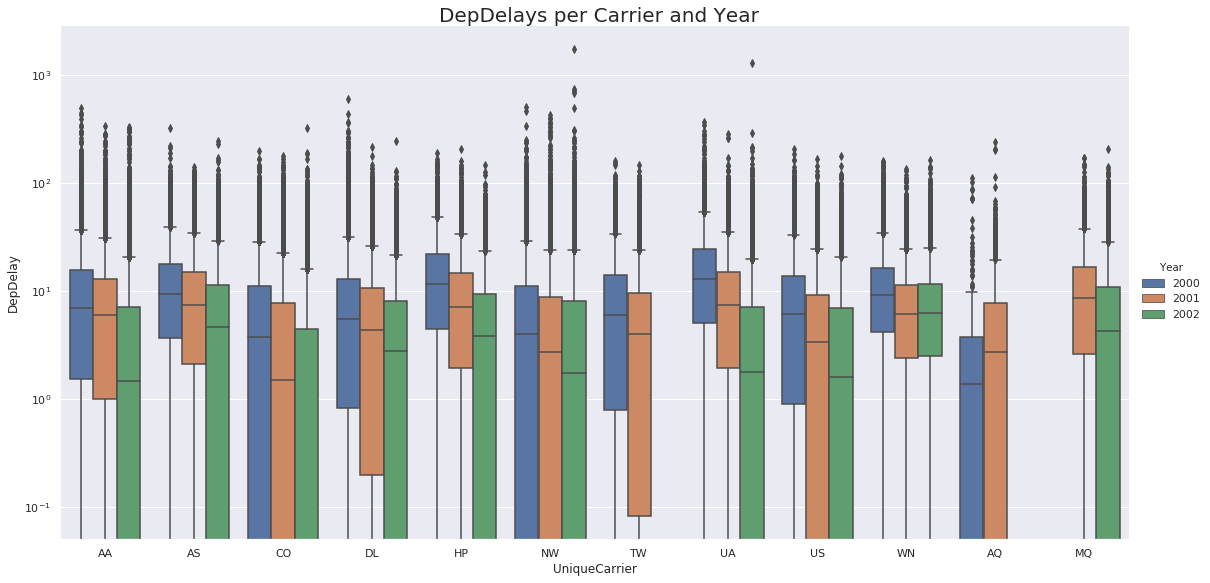

In [25]:
g = sns.catplot(x="UniqueCarrier", y="DepDelay", hue="Year", kind="box", data=df_agg, height=8, aspect=2);
g.set(yscale="log");
g.fig.suptitle('DepDelays per Carrier and Year', fontsize=20, y = 1.01);

## DepDelays during September 2001

* Flights came to a hold on the 9/12th of 2001.
* They started again the following day but with significantly more delaysthan usual.

In [26]:
df_tmp3 = df3[df3['Year'] == 2001]
df_tmp3 = df_tmp3[df_tmp3['Month'] == 9]

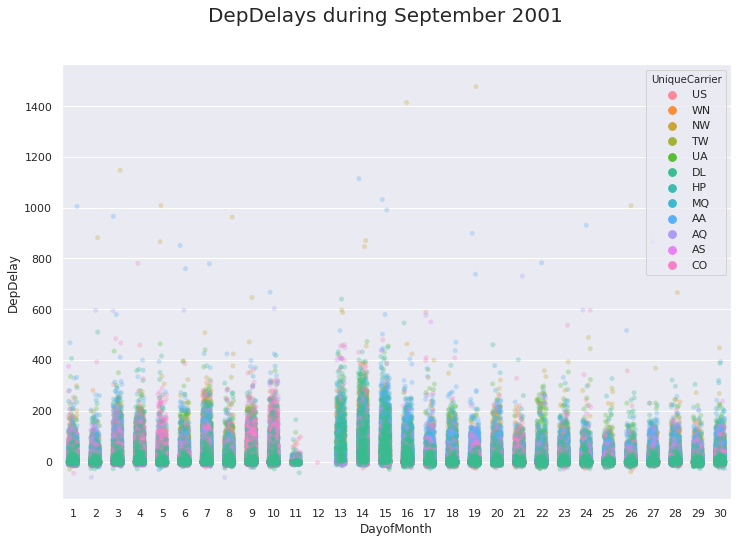

In [27]:
f = plt.figure(figsize=(12, 8))
#ax = sns.scatterplot(x='DayofMonth', y="DepDelay", hue='UniqueCarrier', size='Distance', sizes=(10, 100),  data=df_tmp3, alpha = 0.5)
ax = sns.stripplot(x='DayofMonth', y="DepDelay", hue='UniqueCarrier', data=df_tmp3, alpha = 0.3, jitter = 0.2)
f.suptitle('DepDelays during September 2001', fontsize=20);

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

* Analyzing each carrier individually reasserts the notion that overall DepDelays improve each year.
* The effect of 9/11 can be seen very clearly in the dataset, for both long and short term.

### Were there any interesting or surprising interactions between features?

* Travel distance doesn't seem to correlate with delays, this means that most delays are caused while still on the ground.

In [ ]:
from subprocess import call
call(["python", "-m", "nbconvert", "P5_explanation_slidedeck.ipynb", "--to", "slides", "--post", "serve", "--template", "output_toggle"])